# Yu-Gutnisky-2016 - A DataJoint example
This notebook presents data and results associated with the following papers:

>Jianing Yu, Diego A Gutnisky, S Andrew Hires & Karel Svoboda1. "Layer 4 fast-spiking interneurons filter thalamocortical signals during active somatosensation" (2016) Nat Neurosci (https://dx.doi.org/10.1038/nn.4412)

Original data shared here: http://crcns.org/data-sets/ssc/ssc-7

The data in original NWB 1 format (.nwb) have been ingested into a DataJoint data pipeline presented below. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper.

In [1]:
from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis, virus,
                      intracellular, extracellular, behavior, utilities)

Connecting root@127.0.0.1:3306


In [2]:
%matplotlib inline 

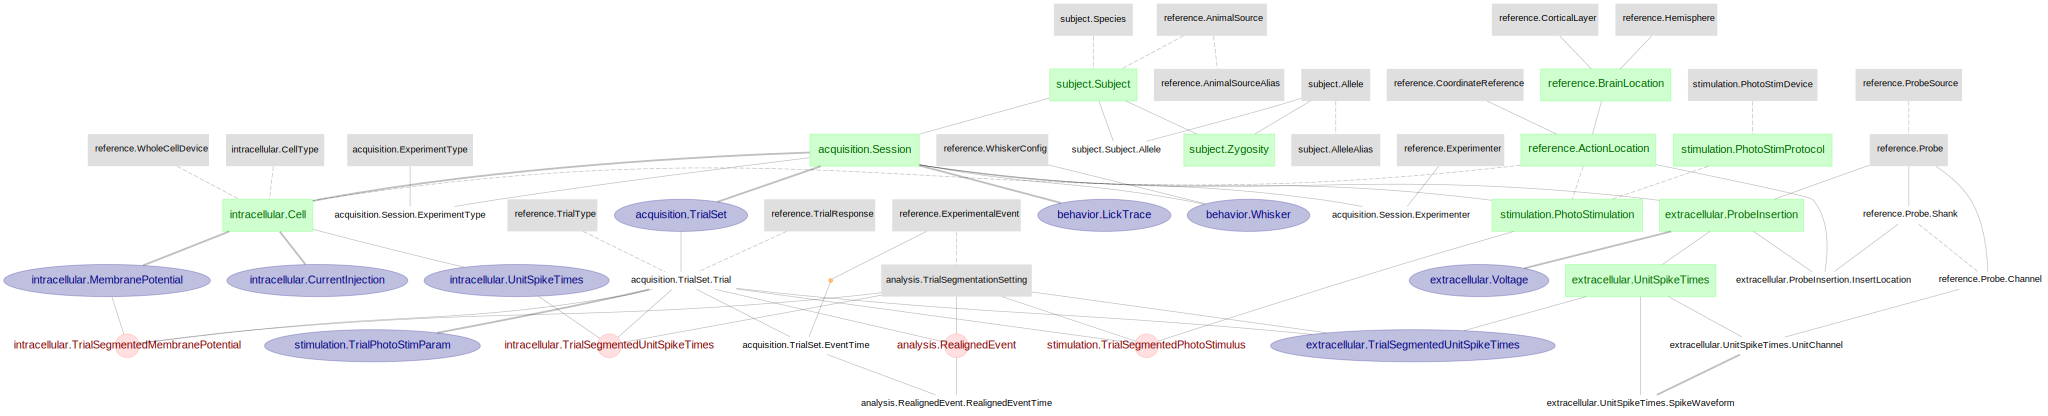

In [16]:
all_erd = (dj.ERD(reference) + dj.ERD(subject)
           + dj.ERD(acquisition) + dj.ERD(analysis)
           + dj.ERD(stimulation) + dj.ERD(behavior)
           + dj.ERD(extracellular) + dj.ERD(intracellular))
dj.ERD(all_erd)

## Replication of Figure 1 (b, d, e) - VPM

In [24]:
session_key = acquisition.Session & 'session_id = "ANM199549_20130530"'

In [25]:
trial_start, trial_stop = (acquisition.TrialSet.Trial & session_key).fetch('start_time', 'stop_time')

In [26]:
# get behavioral data from the principal whisker
dis_to_pole, touch_on, touch_off, whisk_pos, whisk_curv, b_tvec = (behavior.Whisker & session_key & 'principal_whisker=1').fetch1(
    'distance_to_pole', 'touch_onset', 'touch_offset', 'whisker_angle', 'whisker_curvature', 'behavior_timestamps')

In [27]:
b_tvec = b_tvec * 1000

In [28]:
touch_on = np.where(touch_on==1, touch_on, np.nan)
touch_off = np.where(touch_off==1, touch_off, np.nan)

In [29]:
spike_times = (extracellular.UnitSpikeTimes & session_key).fetch1('spike_times')
lick_traces, lick_tvec = (behavior.LickTrace & session_key).fetch1('lick_trace', 'lick_trace_timestamps')

### Perform segmentation aligning to trial-start

In [30]:
# segment: 0 to 5s of trial_start
event_times = trial_start
pre_dur = 0
post_dur = 5
b_fs = round(1/np.median(np.diff(b_tvec)))

In [31]:
segmented_spikes = [spike_times[np.logical_and(spike_times > t - pre_dur, 
                                                   spike_times < t + post_dur)] - t for t in event_times]

In [32]:
segmented_lick_traces = np.vstack([lick_traces[np.logical_and(lick_tvec >= t - pre_dur, lick_tvec < t + post_dur)]
                                   for t in event_times])

In [33]:
segmented_behav = {k: np.vstack([d[np.logical_and(b_tvec >= t - pre_dur, b_tvec < t + post_dur)]
                                 for t in event_times]) 
                   for k, d in zip(('touch_on', 'touch_off', 'whisk_pos', 'whisk_curv'), 
                                   (touch_on, touch_off, whisk_pos, whisk_curv))}

### Figure 1b

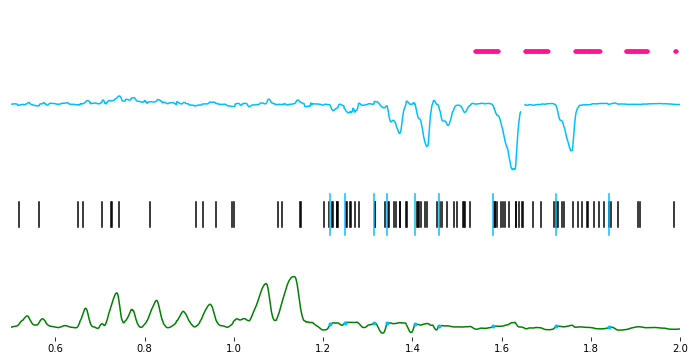

In [249]:
trial_num = 348
fig1a, axs = plt.subplots(4, 1, figsize=(12, 6))
fig1a.subplots_adjust(hspace=0.01)

axs[0].plot(seg_btvec, np.where(segmented_lick_traces[trial_num, :] > 0, segmented_lick_traces[trial_num, :], np.nan),
            '.', color='deeppink')
axs[1].plot(seg_btvec, segmented_behav['whisk_curv'][trial_num, :], 'deepskyblue')
for x in segmented_spikes[trial_num]:
    axs[2].axvline(x, 0.35, 0.65, color='k')
for x in seg_btvec[segmented_behav['touch_on'][trial_num, :]==1]:
    axs[2].axvline(x, 0.25, 0.75, color='deepskyblue')
axs[3].plot(seg_btvec, segmented_behav['whisk_pos'][trial_num, :], 'g')
axs[3].plot(seg_btvec, segmented_behav['whisk_pos'][trial_num, :]*segmented_behav['touch_on'][trial_num, :], '.', c='deepskyblue')

for a in axs:
    a.set_xlim((-pre_dur, post_dur))
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.set_yticks([])
    a.set_xlim((0.5, 2))
for a in axs[:-1]:
    a.set_xticks([])

### Figure 1d

Build touch-triggered PSTH

In [68]:
# touch times
touch_onset = b_tvec[touch_on==1]
touch_offset = b_tvec[touch_off==1]
# inter-touch-interval - of each touch
iti = (touch_onset[1:] - touch_offset[:-1]) 

In [69]:
# get touch-onset that has inter-touch-interval of at least 25ms
touch_onset = touch_onset[:-1][iti > 25e-3]

In [73]:
# segment: -25ms to 50ms of touch-time
pre_touch = 25e-3
post_touch = 50e-3

In [71]:
# touch-aligned spike-times
touch_aligned_spikes = [spike_times[np.logical_and(spike_times > t_touch - pre_touch, 
                                                   spike_times < t_touch + post_touch)] - t_touch
                        for t_touch in touch_onset]

In [78]:
# touch-aligned Whisker Curvature
touch_aligned_curvature = [whisk_curv[np.logical_and(b_tvec >= t_touch - pre_touch,
                                                     b_tvec < t_touch + post_touch)] for t_touch in touch_onset]
min_len = min([len(b) for b in touch_aligned_curvature])
touch_aligned_curvature = np.vstack([t[:min_len] for t in touch_aligned_curvature])
seg_btvec = np.linspace(-pre_touch, post_touch, touch_aligned_curvature.shape[1])

In [180]:
# trial-average spike histogram
def build_raster_and_PSTH(spike_times, timerange, bin_size=0.05):
    np.random.shuffle(spike_times)
    stacked_spikes = np.hstack(spike_times)
    stacked_trials = np.hstack([np.full_like(r, idx) if r.size > 0 else [] for idx, r in enumerate(spike_times)])
    spk_counts, spk_edges = np.histogram(stacked_spikes, bins=int((timerange[-1] - timerange[0]) / bin_size), range=timerange)
    spk_rates = spk_counts / np.diff(spk_edges) / len(spike_times)
    return stacked_spikes, stacked_trials, spk_rates, spk_edges[:-1]

In [200]:
stacked_spikes, stacked_trials, spk_rates, spk_edges = build_raster_and_PSTH(
    touch_aligned_spikes, (-pre_touch, post_touch), bin_size=0.001)

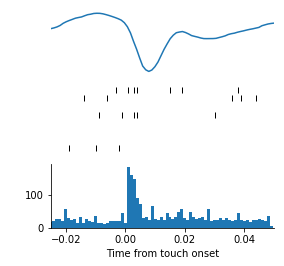

In [201]:
fig1cd, axs = plt.subplots(3, 1, figsize=(4, 4))
axs[0].plot(seg_btvec, np.nanmean(touch_aligned_curvature, axis=0))
axs[1].plot(stacked_spikes[:20], stacked_trials[:20], '|', color='k')
axs[2].bar(spk_edges, spk_rates, width=0.001)
axs[1].set_ylabel('Spike rate')
for a in axs[:-1]:
    a.set_xlim((t_vec[0], t_vec[-1]))
    a.set_axis_off()
    a.set_xlabel([])
axs[-1].set_xlim((t_vec[0], t_vec[-1]))
axs[-1].set_xlabel('Time from touch onset')
axs[-1].spines["top"].set_visible(False)
axs[-1].spines["right"].set_visible(False)

## Replication of Figure 1 (g, h, i, j) - L4 excitatory cell

In [872]:
cell_key = intracellular.Cell & {'session_id': 'JY0861AAAA'}

In [873]:
trial_start, trial_stop = (acquisition.TrialSet.Trial & cell_key).fetch('start_time', 'stop_time')

In [874]:
# get behavioral data from the principal whisker
dis_to_pole, touch_on, touch_off, whisk_pos, whisk_curv, b_tvec = (behavior.Whisker & cell_key & 'principal_whisker=1').fetch1(
    'distance_to_pole', 'touch_onset', 'touch_offset', 'whisker_angle', 'whisker_curvature', 'behavior_timestamps')

In [875]:
diff_btvec = np.diff(b_tvec);
tr_break_idx = np.where(diff_btvec > 1)[0]
tr_break_idx = tr_break_idx + 1
tr_break_idx = np.concatenate([[0], tr_break_idx, [len(b_tvec)]])
b_tvec = np.hstack([(b_tvec[start:end] - b_tvec[start])*1e3 + b_tvec[start] 
                     for start, end in zip(tr_break_idx[:-1], tr_break_idx[1:])])

In [876]:
touch_on = np.where(touch_on==1, touch_on, np.nan)
touch_off = np.where(touch_off==1, touch_off, np.nan)

In [877]:
Vm, v_tvec = (intracellular.MembranePotential & cell_key).fetch1('membrane_potential', 'membrane_potential_timestamps')
spike_times = (intracellular.UnitSpikeTimes & cell_key).fetch1('spike_times')
lick_traces, l_tvec = (behavior.LickTrace & cell_key).fetch1('lick_trace', 'lick_trace_timestamps')

In [943]:
v_tvec = v_tvec - 0.01

#### Perform segmentation aligning to trial-start

In [878]:
def segment_timeseries(data, timestamps, event_times, pre_dur, post_dur):
    d_seg = [data[np.logical_and(timestamps > t - pre_dur, timestamps <= t + post_dur)] for t in event_times]
    t_seg = [timestamps[np.logical_and(timestamps > t - pre_dur, timestamps <= t + post_dur)] - t for t in event_times]
    return d_seg, t_seg

In [879]:
# segment: 0 to 5s of trial_start
event_times = trial_start
pre_dur = 0
post_dur = 5

In [880]:
segmented_spikes = [spike_times[np.logical_and(spike_times > t - pre_dur, spike_times < t + post_dur)] - t for t in event_times]

In [881]:
segmented_Vm, segmented_vtvec = segment_timeseries(Vm, v_tvec, event_times, pre_dur, post_dur)

In [882]:
segmented_lick_traces, segmented_ltvec = segment_timeseries(lick_traces, l_tvec, event_times, pre_dur, post_dur)

In [884]:
segmented_behav = {k: segment_timeseries(d, b_tvec, event_times, pre_dur, post_dur)[0]
                   for k, d in zip(('dis_to_pole', 'touch_on', 'touch_off', 'whisk_pos', 'whisk_curv'), 
                                   (dis_to_pole, touch_on, touch_off, whisk_pos, whisk_curv))}
segmented_btvec = segment_timeseries(whisk_pos, b_tvec, event_times, pre_dur, post_dur)[1]

#### Figure 1g

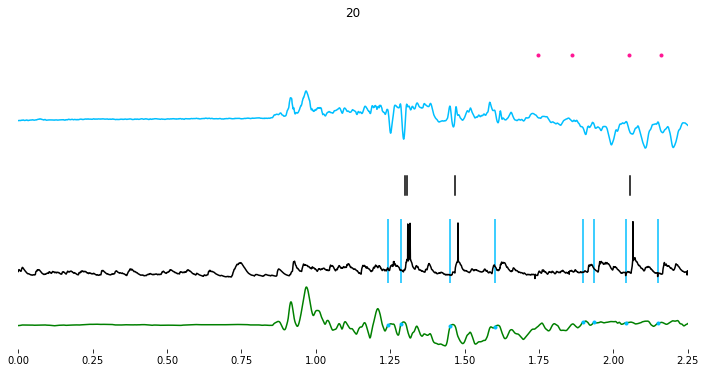

In [885]:
trial_num = 20
fig1a, axs = plt.subplots(5, 1, figsize=(12, 6))
fig1a.subplots_adjust(hspace=0.01)

axs[0].plot(segmented_ltvec[trial_num],
            np.where(segmented_lick_traces[trial_num] > 0, segmented_lick_traces[trial_num], np.nan),
            '.', color='deeppink')
axs[1].plot(segmented_btvec[trial_num], segmented_behav['whisk_curv'][trial_num], 'deepskyblue')
for x in segmented_spikes[trial_num]:
    axs[2].axvline(x, 0.35, 0.65, color='k')
for x in segmented_btvec[trial_num][segmented_behav['touch_on'][trial_num]==1]:
    axs[3].axvline(x, color='deepskyblue')
axs[3].plot(segmented_vtvec[trial_num], segmented_Vm[trial_num], 'k')
axs[4].plot(segmented_btvec[trial_num], segmented_behav['whisk_pos'][trial_num], 'g')
axs[4].plot(segmented_btvec[trial_num], segmented_behav['whisk_pos'][trial_num]*segmented_behav['touch_on'][trial_num],
            '.', c='deepskyblue')

axs[0].set_title(trial_num)
for a in axs:
    a.set_xlim((-pre_dur, post_dur))
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.set_yticks([])
    a.set_xlim((0, 2.25))
for a in axs[:-1]:
    a.set_xticks([])

#### Build touch-triggered PSTH 

In [944]:
# touch times
touch_onset = b_tvec[touch_on==1]
touch_offset = b_tvec[touch_off==1]

In [945]:
# inter-touch-interval - of each touch
iti = (touch_onset[1:] - touch_offset[:-1]) 
# get touch-onset that has inter-touch-interval of at least 25ms
touch_onset = touch_onset[:-1][iti >= 25e-3]

In [946]:
# segment: -25ms to 50ms of touch-time
pre_touch = 0.025
post_touch = 0.05

In [947]:
# touch-aligned spike-times
touch_aligned_spikes = [spike_times[np.logical_and(spike_times > t_touch - pre_touch, 
                                                   spike_times <= t_touch + post_touch)] - t_touch
                        for t_touch in touch_onset]

In [948]:
# touch-aligned Vm
touch_aligned_Vm, touch_aligned_vtvec = segment_timeseries(Vm, v_tvec, touch_onset, pre_touch, post_touch)

In [949]:
# touch-aligned Whisker Curvature
touch_aligned_curvature, touch_aligned_btvec = segment_timeseries(whisk_curv, b_tvec, touch_onset, pre_touch, post_touch)

In [950]:
touch_aligned_curvature = [np.where((k - k[:1000].mean()) < 0, k - k.mean(), 0) for k in touch_aligned_curvature]

In [951]:
stacked_spikes, stacked_trials, spk_rates, spk_edges = build_raster_and_PSTH(
    touch_aligned_spikes, (-pre_touch, post_touch), bin_size=0.001)

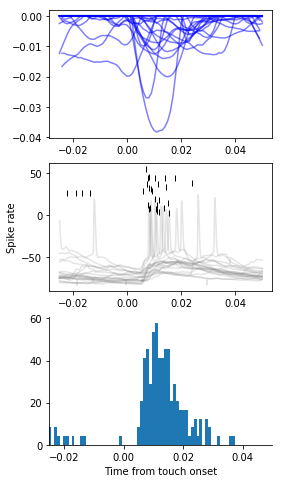

In [954]:
fig1cd, axs = plt.subplots(3, 1, figsize=(4, 8))

rand_trials = np.random.randint(len(touch_aligned_curvature), size=20)

for k in rand_trials:
    axs[0].plot(touch_aligned_btvec[k], touch_aligned_curvature[k], color='b', alpha=0.5)

for k in rand_trials:
    axs[1].plot(touch_aligned_vtvec[k], touch_aligned_Vm[k], color='gray', alpha=0.2)

axs[1].plot(stacked_spikes[:30], stacked_trials[:30], '|', color='k')
axs[2].bar(spk_edges, spk_rates, width=0.001)
axs[1].set_ylabel('Spike rate')
for a in axs[:-1]:
    a.set_xlim((-pre_touch, post_touch))
    a.set_axis_off()
    a.set_xlabel([])
axs[-1].set_xlim((-pre_touch, post_touch))
axs[-1].set_xlabel('Time from touch onset')
axs[-1].spines["top"].set_visible(False)
axs[-1].spines["right"].set_visible(False)